In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from datetime import datetime
#%matplotlib notebook
torch.manual_seed(42)
import warnings
warnings.filterwarnings('ignore')
import os
path = os.path.join(os.getcwd(), "plot/")
today=datetime.today().strftime('%Y-%m-%d')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class OptimizerAgent:
    def __init__(self, true_p, lr=0.1, q_init=0.5):
        """
        The optimizer knows the true p and chooses q* to maximize expected reward.
        :param true_p: The true probability of success.
        :param lr: Learning rate for optimizing q.
        :param q_init: Initial guess for the probability to report.
        """
        self.true_p = true_p
        self.q = torch.tensor([q_init], requires_grad=True)  # Trainable q
        self.optimizer = torch.optim.SGD([self.q], lr=lr)

    def quadratic_loss(self, q, y):
        """Quadratic scoring rule loss."""
        return (y - q) ** 2

    def expected_loss(self, q):
        """
        Compute the expected loss given the true p.
        E[loss] = p * loss(q, 0) + (1 - p) * loss(q, 1)
        """
        loss_0 = self.quadratic_loss(q, torch.tensor(0.0))  # Loss if outcome is 0
        loss_1 = self.quadratic_loss(q, torch.tensor(1.0))  # Loss if outcome is 1
        return (1-self.true_p) * loss_0 + self.true_p * loss_1

    def optimize_q(self, steps=100):
        """Optimize q* to minimize expected loss."""
        for _ in range(steps):
            self.optimizer.zero_grad()
            loss = self.expected_loss(self.q)
            loss.backward()
            self.optimizer.step()
            self.q.data.clamp_(0, 1)  # Keep q in [0,1]
        return self.q.item()

class No_Decision_Agent:
    def __init__(self, q):
        """
        The elicitor receives q* and samples an outcome.
        :param q: The optimized probability from the optimizer agent.
        """
        self.q = q

    def sample_outcome(self):
        """Sample y ~ Bernoulli(q)."""
        return torch.bernoulli(torch.tensor(self.q)).item()

    def provide_feedback(self, y):
        """Provide feedback using the negative quadratic loss."""
        return ((y - self.q) ** 2)

# Define true p
true_p = 0.7

# Step 1: Optimizer chooses q* to maximize expected reward
optimizer = OptimizerAgent(true_p, lr=0.1)
q_star = optimizer.optimize_q()
print(f"Optimized q*: {q_star:.4f} (True p: {true_p})")

# Step 2: Elicitor receives q*, samples y, and provides feedback
elicitor = No_Decision_Agent(q_star)
y_sampled = elicitor.sample_outcome()
feedback = elicitor.provide_feedback(y_sampled)

print(f"Elicitor sampled y = {y_sampled}, Feedback = {feedback:.4f}")

Optimized q*: 0.7000 (True p: 0.7)
Elicitor sampled y = 0.0, Feedback = 0.4900


In [3]:
## Randomized Aggregation setup
class ImpreciseOptimizerAgent:
    def __init__(self, mu, sigma, aggregation, lr=0.1, report_params_init=[0.5,0.2]):
        """
        The optimizer knows the true p and chooses q* to maximize expected reward.
        :param true_p: The true probability of success.
        :param lr: Learning rate for optimizing q.
        :param q_init: Initial guess for the probability to report.
        """
        self.true_mu, self.true_sigma = mu, sigma
        self.aggregation = aggregation
        self.report_raw_mu = torch.tensor([report_params_init[0]], requires_grad=True)
        self.report_raw_sigma = torch.tensor([report_params_init[0]], requires_grad=True)
        self.optimizer = torch.optim.SGD([self.report_raw_mu, self.report_raw_sigma], lr=lr)

    def quadratic_loss(self, q, y):
        """Quadratic scoring rule loss."""
        return (y - q) ** 2

    def expected_loss(self, report_mu, report_sigma):
        """
        Compute the expected loss given the true p.
        E[loss] = p * loss(q, 0) + (1 - p) * loss(q, 1)
        """
        true_p = self.aggregation*(self.true_mu-self.true_sigma)+(1-self.aggregation)*(self.true_mu+self.true_sigma)
        # closed form solution to a\in [0,1] and u:A X Y -> R being a strictly convex function like (y-a)**2 
        a_star_q = self.aggregation*(report_mu-report_sigma)+(1-self.aggregation)*(report_mu+report_sigma) 
        loss_0 = self.quadratic_loss(a_star_q, torch.tensor(0.0))  # Loss if outcome is 0
        loss_1 = self.quadratic_loss(a_star_q, torch.tensor(1.0))  # Loss if outcome is 1
        return (1-true_p) * loss_0 + true_p * loss_1
    
    def get_params(self):
        """
        Reparameterize raw_mu and raw_sigma to enforce:
          - μ ∈ (0,1) via a sigmoid,
          - σ ∈ [0, min(μ, 1-μ)] by scaling another sigmoid.
        """
        # Force μ into (0,1)
        mu = torch.sigmoid(self.report_raw_mu)
        # Determine maximum σ allowed so that μ-σ >= 0 and μ+σ <= 1
        sigma_max = torch.min(mu, 1 - mu)
        # Force σ into [0, sigma_max]
        sigma = torch.sigmoid(self.report_raw_sigma) * sigma_max
        return mu, sigma
    
    def optimize_IP(self, steps=1000):
        """Optimize q* to minimize expected loss."""
        for _ in range(steps):
            self.optimizer.zero_grad()
            report_mu, report_sigma = self.get_params()
            loss = self.expected_loss(report_mu, report_sigma)
            loss.backward()
            self.optimizer.step()
        return [item.item() for item in self.get_params()]

class No_Decision_Agent:
    def __init__(self, mu, sigma, aggregation=0.5):
        """
        The elicitor receives q* and samples an outcome.
        :param q: The optimized probability from the optimizer agent.
        """
        self.nature = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1) # random outcome from nature 
        self.aggregation = aggregation
        self.mu, self.sigma = mu, sigma
        self.a = self.aggregation*(self.mu-self.sigma)+(1-self.aggregation)*(self.mu+self.sigma) 
        self.outcome = self.sample_outcome()
        
    def sample_outcome(self):
        """Sample y ~ Bernoulli(q)."""
        return torch.bernoulli(torch.tensor(self.nature)).item()
    
    def update_the_reports(self, mu, sigma):
        self.mu, self.sigma = mu, sigma
        self.a = self.aggregation*(self.mu-self.sigma)+(1-self.aggregation)*(self.mu+self.sigma)
        return 
    
    def provide_feedback(self):
        """Provide feedback using the negative quadratic loss."""
        return ((self.outcome - self.a) ** 2)

# Define true p
true_mu, true_sigma = 0.1, 0.05
aggregation = 0.5
# Step 1: Optimizer chooses q* to maximize expected reward
optimizer = ImpreciseOptimizerAgent(mu=true_mu,sigma=true_sigma, aggregation=aggregation, lr=0.1)
q_star = optimizer.optimize_IP()
print(f"Optimized q*: {q_star[0]-q_star[1]:.4f} {q_star[0]+q_star[1]:.4f} (True p: {true_mu-true_sigma} {true_mu+true_sigma})")

# Step 2: Elicitor receives q*, samples y, and provides feedback
elicitor = No_Decision_Agent(q_star[0],q_star[1], aggregation)
feedback = elicitor.provide_feedback()

print(f"Elicitor sampled y = {elicitor.outcome}, Feedback = {feedback:.4f}")

elicitor.update_the_reports(0.1, 0.0)
feedback = elicitor.provide_feedback()
print(f"Elicitor sampled y = {elicitor.outcome}, Feedback = {feedback:.4f}")

elicitor.update_the_reports(0.1, 0.05)
feedback = elicitor.provide_feedback()
print(f"Elicitor sampled y = {elicitor.outcome}, Feedback = {feedback:.4f}")

elicitor.update_the_reports(0.5, 0.5)
feedback = elicitor.provide_feedback()
print(f"Elicitor sampled y = {elicitor.outcome}, Feedback = {feedback:.4f}")

Optimized q*: 0.0419 0.1801 (True p: 0.05 0.15000000000000002)
Elicitor sampled y = 0.0, Feedback = 0.0123
Elicitor sampled y = 0.0, Feedback = 0.0100
Elicitor sampled y = 0.0, Feedback = 0.0100
Elicitor sampled y = 0.0, Feedback = 0.2500


In [4]:
## Randomized Aggregation setup with [μ-σ, μ+σ]
class ImpreciseOptimizerAgent:
    def __init__(self, mu, sigma, lr=0.1, report_params_init=[0.5,0.2]):
        """
        The optimizer knows the true p and chooses q* to maximize expected reward.
        :param true_p: The true probability of success.
        :param lr: Learning rate for optimizing q.
        :param q_init: Initial guess for the probability to report.
        """
        self.true_mu, self.true_sigma = mu, sigma
        self.report_raw_mu = torch.tensor([report_params_init[0]], requires_grad=True)
        self.report_raw_sigma = torch.tensor([report_params_init[0]], requires_grad=True)
        self.optimizer = torch.optim.SGD([self.report_raw_mu, self.report_raw_sigma], lr=lr)

    def quadratic_loss(self, q, y):
        """Quadratic scoring rule loss."""
        return (y - q) ** 2

    def expected_loss(self, report_mu, report_sigma, aggregation):
        """
        Compute the expected loss given the true p.
        E[loss] = p * loss(q, 0) + (1 - p) * loss(q, 1)
        """
        true_p = aggregation*(self.true_mu-self.true_sigma)+(1-aggregation)*(self.true_mu+self.true_sigma)
        # closed form solution to a\in [0,1] and u:A X Y -> R being a strictly convex function like (y-a)**2 
        a_star_q = aggregation*(report_mu-report_sigma)+(1-aggregation)*(report_mu+report_sigma) 
        loss_0 = self.quadratic_loss(a_star_q, torch.tensor(0.0))  # Loss if outcome is 0
        loss_1 = self.quadratic_loss(a_star_q, torch.tensor(1.0))  # Loss if outcome is 1
        return (1-true_p) * loss_0 + true_p * loss_1
    
    def get_params(self):
        """
        Reparameterize raw_mu and raw_sigma to enforce:
          - μ ∈ (0,1) via a sigmoid,
          - σ ∈ [0, min(μ, 1-μ)] by scaling another sigmoid.
        """
        # Force μ into (0,1)
        mu = torch.sigmoid(self.report_raw_mu)
        # Determine maximum σ allowed so that μ-σ >= 0 and μ+σ <= 1
        sigma_max = torch.min(mu, 1 - mu)
        # Force σ into [0, sigma_max]
        sigma = torch.sigmoid(self.report_raw_sigma) * sigma_max
        return mu, sigma
    
    def optimize_IP(self, steps=100):
        """Optimize q* to minimize expected loss."""
        for _ in range(steps):
            self.optimizer.zero_grad()
            loss = 0
            for aggregation in torch.rand(100):
                report_mu, report_sigma = self.get_params()
                loss += self.expected_loss(report_mu, report_sigma, aggregation)
            loss.backward()
            self.optimizer.step()
        return [item.item() for item in self.get_params()]

class No_Decision_Agent:
    def __init__(self, mu, sigma, aggregation=0.5):
        """
        The elicitor receives q* and samples an outcome.
        :param q: The optimized probability from the optimizer agent.
        """
        self.nature = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1) # random outcome from nature 
        self.aggregation = aggregation
        self.mu, self.sigma = mu, sigma
        self.a = self.aggregation*(self.mu-self.sigma)+(1-self.aggregation)*(self.mu+self.sigma) 
    def sample_outcome(self):
        """Sample y ~ Bernoulli(q)."""
        return torch.bernoulli(torch.tensor(self.nature)).item()

    def provide_feedback(self, y):
        """Provide feedback using the negative quadratic loss."""
        return ((y - self.a) ** 2)

# Define true p
true_mu, true_sigma = 0.1, 0.05
aggregation = 0.5
# Step 1: Optimizer chooses q* to maximize expected reward
optimizer = ImpreciseOptimizerAgent(mu=true_mu,sigma=true_sigma, lr=0.1)
q_star = optimizer.optimize_IP()
print(f"Optimized q*: {q_star[0]-q_star[1]:.4f} {q_star[0]+q_star[1]:.4f} (True p: {true_mu-true_sigma} {true_mu+true_sigma})")

# Step 2: Elicitor receives q*, samples y, and provides feedback
elicitor = No_Decision_Agent(q_star[0],q_star[1], aggregation)
y_sampled = elicitor.sample_outcome()
feedback = elicitor.provide_feedback(y_sampled)

print(f"Elicitor sampled y = {y_sampled}, Feedback = {feedback:.4f}")

Optimized q*: 0.0430 0.1547 (True p: 0.05 0.15000000000000002)
Elicitor sampled y = 1.0, Feedback = 0.8120


In [5]:
## Randomized Aggregation setup with p_low and p_up
class ImpreciseOptimizerAgent:
    def __init__(self, p_low, p_up, lr=0.1, report_params_init=[0.2,0.5]):
        """
        The optimizer knows the true p and chooses q* to maximize expected reward.
        :param true_p: The true probability of success.
        :param lr: Learning rate for optimizing q.
        :param q_init: Initial guess for the probability to report.
        """
        self.p_low, self.p_up = p_low, p_up
        self.report_p_low = torch.tensor([report_params_init[0]], requires_grad=True)
        self.report_p_up = torch.tensor([report_params_init[0]], requires_grad=True)
        self.optimizer = torch.optim.SGD([self.report_p_low, self.report_p_up], lr=lr)

    def quadratic_loss(self, q, y):
        """Quadratic scoring rule loss."""
        return (y - q) ** 2

    def expected_loss(self, report_low, report_up, aggregation):
        """
        Compute the expected loss given the true p.
        E[loss] = p * loss(q, 0) + (1 - p) * loss(q, 1)
        """
        true_p = aggregation*(self.p_low)+(1-aggregation)*(self.p_up)
        # closed form solution to a\in [0,1] and u:A X Y -> R being a strictly convex function like (y-a)**2 
        a_star_q = aggregation*(report_low)+(1-aggregation)*(report_up) 
        loss_0 = self.quadratic_loss(a_star_q, torch.tensor(0.0))  # Loss if outcome is 0
        loss_1 = self.quadratic_loss(a_star_q, torch.tensor(1.0))  # Loss if outcome is 1
        return (1-true_p) * loss_0 + true_p * loss_1
    
    def get_params(self):
        # Force μ into (0,1)
        p_low = torch.sigmoid(self.report_p_low)
        p_up = torch.sigmoid(self.report_p_up)
        return p_low, p_up
    
    def optimize_IP(self, steps=1000):
        """Optimize q* to minimize expected loss."""
        for _ in range(steps):
            self.optimizer.zero_grad()
            loss = 0
            for aggregation in torch.rand(100):
                report_mu, report_sigma = self.get_params()
                loss += self.expected_loss(report_mu, report_sigma, aggregation)
            loss.backward()
            self.optimizer.step()
        return [item.item() for item in self.get_params()]

class No_Decision_Agent:
    def __init__(self, q_low, q_up, aggregation=0.5):
        """
        The elicitor receives q* and samples an outcome.
        :param q: The optimized probability from the optimizer agent.
        """
        self.nature = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1) # random outcome from nature 
        self.aggregation = aggregation
        self.q_low, self.q_up = q_low, q_up
        self.a = self.aggregation*(q_low)+(1-self.aggregation)*(q_up) 
    def sample_outcome(self):
        """Sample y ~ Bernoulli(q)."""
        return torch.bernoulli(torch.tensor(self.nature)).item()

    def provide_feedback(self, y):
        """Provide feedback using the negative quadratic loss."""
        return ((y - self.a) ** 2)

# Define true p
p_low, p_up = 0.05, 0.15
# Step 1: Optimizer chooses q* to maximize expected reward
optimizer = ImpreciseOptimizerAgent(p_low,p_up, lr=0.1)
q_star = optimizer.optimize_IP()
print(f"Optimized q*: {q_star[0]:.4f} {q_star[1]:.4f} (True p: {p_low} {p_up})")

# Step 2: Elicitor receives q*, samples y, and provides feedback
elicitor = No_Decision_Agent(q_star[0],q_star[1])
y_sampled = elicitor.sample_outcome()
feedback = elicitor.provide_feedback(y_sampled)

print(f"Elicitor sampled y = {y_sampled}, Feedback = {feedback:.4f}")

Optimized q*: 0.0500 0.1500 (True p: 0.05 0.15)
Elicitor sampled y = 0.0, Feedback = 0.0100


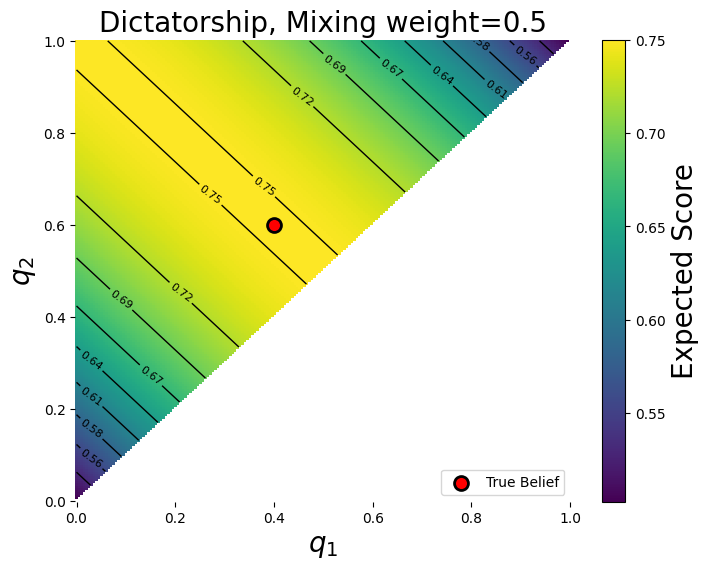

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define true probability interval
p_low, p_up = 0.4, 0.6

# Quadratic scoring function
def quadratic_loss(q, y):
    return (y - q) ** 2 -1

def expected_loss(report_low, report_up, aggregation):
    if report_low > report_up:
        report_low, report_up = report_up, report_low
    """Compute expected loss for a given reported interval."""
    true_p = aggregation * p_low + (1 - aggregation) * p_up
    a_star_q = aggregation * report_low + (1 - aggregation) * report_up
    loss_0 = quadratic_loss(a_star_q, 0.0)  # Loss if outcome is 0
    loss_1 = quadratic_loss(a_star_q, 1.0)  # Loss if outcome is 1
    return (1 - true_p) * loss_0 + true_p * loss_1


# Define range of reported values
q1_vals = np.linspace(0.0, 1.0, 200)
q2_vals = np.linspace(0.0, 1.0, 200)
Q1, Q2 = np.meshgrid(q1_vals, q2_vals)

# Compute average expected loss
Z = np.zeros_like(Q1)
for i in range(Q1.shape[0]):
    for j in range(Q1.shape[1]):
        if j < i:
            Z[i, j] = -expected_loss(Q1[i, j], Q2[i, j], 0.5)
        else:
            Z[i, j] = np.nan
# Create 2D heatmap
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(Q1, Q2, Z, cmap='viridis', shading='auto')  # Negative to show max at true values

# Add contour lines including max level explicitly
contour_levels = np.linspace(np.nanmin(Z), np.nanmax(Z) - 0.001, 10)
contour = ax.contour(Q1, Q2, Z, levels=contour_levels, colors='black', linewidths=1)
ax.clabel(contour, inline=True, fontsize=8, fmt="%.2f")

ax.scatter(p_low, p_up, color='red', s=100, edgecolors='black', linewidth=2, label='True Belief')
fig.colorbar(c, ax=ax, label='Expected Score').set_label('Expected Score', fontsize=20)
ax.set_xlabel(r"$q_1$", fontsize=20)
ax.set_ylabel(r"$q_2$", fontsize=20)
ax.set_title("Dictatorship, Mixing weight=0.5", fontsize=20)
ax.legend(loc='lower right')
ax.set_frame_on(False)
plt.savefig("figs/dictatorship.pdf", format="pdf", bbox_inches="tight")
plt.show()

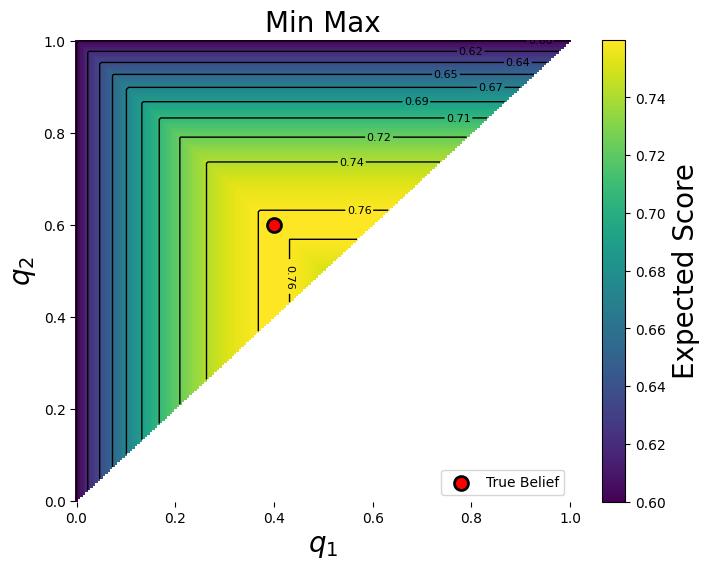

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define true probability interval
p_low, p_up = 0.4, 0.6

# Quadratic scoring function
def quadratic_loss(q, y):
    return (y - q) ** 2 - 1

def utility_of_action(report_low, report_up, action):
    loss_0, loss_1 = quadratic_loss(action, 0.0), quadratic_loss(action, 1.0)
    expected_utility_low = report_low * loss_0 + (1 - report_low) * loss_1
    expected_utility_up = report_up * loss_0 + (1 - report_up) * loss_1
    return np.min([expected_utility_low, expected_utility_up])

def best_action(report_low, report_up):
    utilities = np.array([
        utility_of_action(report_low, report_up, report_low),
        utility_of_action(report_low, report_up, report_up)
    ])
    action_idx = np.argmax(utilities)
    actions = [report_low, report_up]
    return actions[action_idx]

def expected_loss(report_low, report_up):
    if report_low > report_up:
        report_low, report_up = report_up, report_low
    a_star_q = best_action(report_low, report_up)
    loss_0 = quadratic_loss(a_star_q, 0.0)  # Loss if outcome is 0
    loss_1 = quadratic_loss(a_star_q, 1.0)  # Loss if outcome is 1
    loss_low = (1 - p_low) * loss_0 + p_low * loss_1
    loss_up = (1 - p_up) * loss_0 + p_up * loss_1
    return np.min([loss_low, loss_up])

# Define range of reported values
q1_vals = np.linspace(0.0, 1.0, 200)
q2_vals = np.linspace(0.0, 1.0, 200)
Q1, Q2 = np.meshgrid(q1_vals, q2_vals)

# Compute average expected loss
Z = np.zeros_like(Q1)
for i in range(Q1.shape[0]):
    for j in range(Q1.shape[1]):
        if Q2[i, j] < Q1[i, j]:  # Mask lower triangle
            Z[i, j] = np.nan
        else:
            Z[i, j] = -expected_loss(Q1[i, j], Q2[i, j])

# Mask for pcolormesh (doesn't affect contours)
Z_masked = np.ma.masked_where(np.isnan(Z), Z)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot heatmap
c = ax.pcolormesh(Q1, Q2, Z_masked, cmap='viridis', shading='auto')

# Plot contour lines, but using original Z (not masked) to keep them visible
contour_levels = np.linspace(np.nanmin(Z), np.nanmax(Z) - 0.001, 10)
contour = ax.contour(Q1, Q2, Z, levels=contour_levels, colors='black', linewidths=1)
ax.clabel(contour, inline=True, fontsize=8, fmt="%.2f")

# Scatter point for true forecast
ax.scatter(p_low, p_up, color='red', s=100, edgecolors='black', linewidth=2, label='True Belief')

# Colorbar
cbar = fig.colorbar(c, ax=ax)
cbar.set_label('Expected Score', fontsize=20)

# Labels and title
ax.set_xlabel(r"$q_1$", fontsize=20)
ax.set_ylabel(r"$q_2$", fontsize=20)
ax.set_title("Min Max", fontsize=20)
ax.legend(loc='lower right')
ax.set_frame_on(False)
# Save and show
plt.savefig("figs/minmax.pdf", format="pdf", bbox_inches="tight")

plt.show()

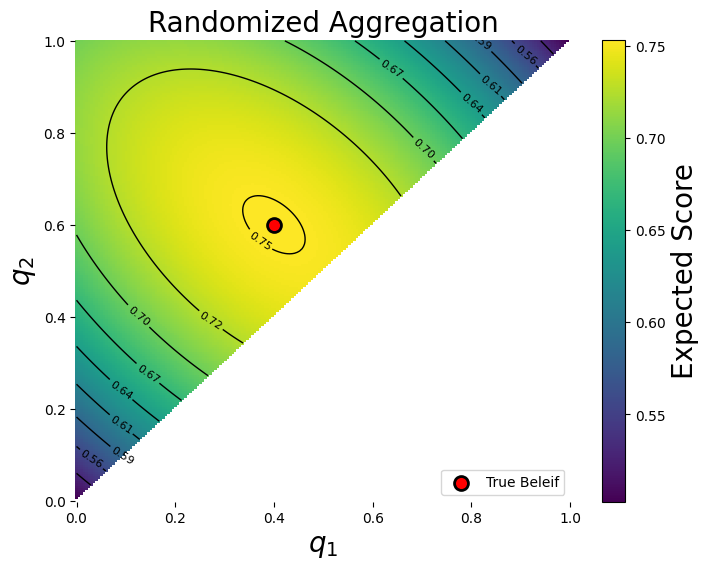

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define true probability interval
p_low, p_up = 0.4, 0.6

# Quadratic scoring function
def quadratic_loss(q, y):
    return (y - q) ** 2 -1

def expected_loss(report_low, report_up, aggregation):
    """Compute expected loss for a given reported interval."""
    true_p = aggregation * p_low + (1 - aggregation) * p_up
    a_star_q = aggregation * report_low + (1 - aggregation) * report_up
    loss_0 = quadratic_loss(a_star_q, 0.0)  # Loss if outcome is 0
    loss_1 = quadratic_loss(a_star_q, 1.0)  # Loss if outcome is 1
    return (1 - true_p) * loss_0 + true_p * loss_1

def average_expected_loss(report_low, report_up, num_samples=1000):
    """Compute the average expected loss over multiple random aggregation samples."""
    losses = [-expected_loss(report_low, report_up, i/num_samples) for i in range(num_samples+1)]
    return np.mean(losses)

# Define range of reported values
q1_vals = np.linspace(0.0, 1.0, 200)
q2_vals = np.linspace(0.0, 1.0, 200)
Q1, Q2 = np.meshgrid(q1_vals, q2_vals)

# Compute average expected loss
Z = np.zeros_like(Q1)
for i in range(Q1.shape[0]):
    for j in range(Q1.shape[1]):
        if j < i:
            Z[i, j] = average_expected_loss(Q1[i, j], Q2[i, j], num_samples=1000)
        else:
            Z[i, j] = np.nan

fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolormesh(Q1, Q2, Z, cmap='viridis', shading='auto')  # Negative to show max at true values

# Plot contour lines, but using original Z (not masked) to keep them visible
contour_levels = np.linspace(np.nanmin(Z), np.nanmax(Z) - 0.001, 10)
contour = ax.contour(Q1, Q2, Z, levels=contour_levels, colors='black', linewidths=1)
ax.clabel(contour, inline=True, fontsize=8, fmt="%.2f")
ax.scatter(p_low, p_up, color='red', s=100, edgecolors='black', linewidth=2, label='True Beleif')

fig.colorbar(c, ax=ax, label='Expected Score').set_label('Expected Score', fontsize=20)
ax.set_xlabel(r"$q_1$", fontsize=20)
ax.set_ylabel(r"$q_2$", fontsize=20)
ax.set_title("Randomized Aggregation", fontsize=20)

ax.legend(loc='lower right')
ax.set_frame_on(False)
plt.savefig("figs/strictly.pdf", format="pdf", bbox_inches="tight")
plt.show()